# 1.Numpy进阶

如果有问题请在群里讨论，题意问题请@姜腾

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1.1 Cauchy matrix

Cauchy矩阵是一种在多个领域（控制论，插值，矩阵论）都有广泛应用的矩阵，具体定义如下引用自[Wikipedia](https://en.wikipedia.org/wiki/Cauchy_matrix#:~:text=In%20mathematics%2C%20a%20Cauchy%20matrix%2C%20named%20after%20Augustin,n%20matrix%20with%20elements%20aij%20in%20the%20form)：

In mathematics, a Cauchy matrix, named after Augustin Louis Cauchy, is an $m \times n$ matrix with elements $a_{i j}$ in the form
$$
a_{i j}=\frac{1}{x_{i}-y_{j}} ; \quad x_{i}-y_{j} \neq 0, \quad 1 \leq i \leq m, \quad 1 \leq j \leq n
$$
where $x_{i}$ and $y_{j}$ are elements of a field $\mathcal{F}$, and $\left(x_{i}\right)$ and $\left(y_{j}\right)$ are injective sequences (they contain distinct elements).

特别的，大家喜闻乐见的希尔伯特矩阵就是在$x_{i}-y_{j}=i+j-1$条件下的一种特殊Cauchy矩阵。

本题要求用两种方法：Ufunc和nditer两种方式实现示例的Cauchy矩阵计算，并将输出打印。

In [2]:
A = np.arange(5).reshape(5,1) + 4
B = np.arange(3).reshape(1,3)
print(A,B)

[[4]
 [5]
 [6]
 [7]
 [8]] [[0 1 2]]


In [3]:
1/(A-B)

array([[0.25      , 0.33333333, 0.5       ],
       [0.2       , 0.25      , 0.33333333],
       [0.16666667, 0.2       , 0.25      ],
       [0.14285714, 0.16666667, 0.2       ],
       [0.125     , 0.14285714, 0.16666667]])

In [6]:
# 使用ufunc

C = np.subtract(A, B)
C = np.divide(1,C)
C

array([[0.25      , 0.33333333, 0.5       ],
       [0.2       , 0.25      , 0.33333333],
       [0.16666667, 0.2       , 0.25      ],
       [0.14285714, 0.16666667, 0.2       ],
       [0.125     , 0.14285714, 0.16666667]])

In [7]:
# 使用nditer

it = np.nditer([A,B],flags=['multi_index'])
C = np.zeros((5,3),dtype = float)
while not it.finished:
    C[it.multi_index] = 1/(it[0] - it[1])
    is_not_finished = it.iternext()
C


array([[0.25      , 0.33333333, 0.5       ],
       [0.2       , 0.25      , 0.33333333],
       [0.16666667, 0.2       , 0.25      ],
       [0.14285714, 0.16666667, 0.2       ],
       [0.125     , 0.14285714, 0.16666667]])

In [7]:
it = np.nditer([A,B,None])
for x,y,z in it: z[...] = x - y
C = 1/it.operands[2]
C

array([[0.25      , 0.33333333, 0.5       ],
       [0.2       , 0.25      , 0.33333333],
       [0.16666667, 0.2       , 0.25      ],
       [0.14285714, 0.16666667, 0.2       ],
       [0.125     , 0.14285714, 0.16666667]])

### 1.2 Element-wise计算的性能分析

以下是一些将一个矩阵每个元素平方的函数实现。结合课上内容，查阅资料，总结出5条以上有意义的发现。


如：
1. 用户自定义的ufunc性能不如numpy自带的ufunc，是因为numpy自带函数底层用C实现。

In [11]:
import timeit
from numba import jit

data = np.random.randint(10, size=(500, 300))

def pow_build_in(d):
    return data*data

def pow_ufunc(d):
    return np.square(d)

def pow_my_ufunc(d):
    return np.frompyfunc(lambda x:x*x,1,1)(d)

def pow_loop(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        for j in range(300): 
            res[i,j]=d[i,j] ** 2 
    return res

@jit
def pow_loop_jit(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        for j in range(300): 
            res[i,j]=d[i,j] ** 2 
    return res

def pow_loop_per_row(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        res[i,:] = d[i,:] ** 2 
    return res

@jit
def pow_loop_per_row_jit(d): 
    res = np.zeros_like(d) 
    for i in range(500): 
        res[i,:] = d[i,:] ** 2 
    return res

def pow_nditer_default(d):
    res = np.zeros_like(d) 
    it = np.nditer([d, res], op_flags=['readwrite']) 
    for i, r in it:
        r[...] = i ** 2 
        return res 

def pow_nditer_multi(d):
    res = np.zeros_like(d) 
    it = np.nditer([d, res], flags =['multi_index'], op_flags=['readwrite']) 
    for i, r in it: 
        r[...] = i ** 2 
        return res 

def pow_nditer_ext_by_C(d): 
    d = np.array(d, order = 'C') 
    res = np.zeros_like(d, order = 'C') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='C') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 

def pow_nditer_ext_by_F(d): 
    d = np.array(d, order = 'F') 
    res = np.zeros_like(d, order = 'F') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='F') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 

def pow_nditer_ext_bad(d):  
    d = np.array(d, order = 'C') 
    res = np.zeros_like(d, order = 'C') 
    it = np.nditer([d, res], flags = ['external_loop'], op_flags=['readwrite'], order='F') 
    for i, r in it: 
        r[...] = i ** 2 
    return res 


%timeit pow_build_in(data)
%timeit pow_ufunc(data)
%timeit pow_my_ufunc(data)
%timeit pow_loop(data)
%timeit pow_loop_jit(data)
%timeit pow_loop_per_row(data)
%timeit pow_loop_per_row_jit(data)
%timeit pow_nditer_default(data)
%timeit pow_nditer_multi(data)
%timeit pow_nditer_ext_by_C(data)
%timeit pow_nditer_ext_by_F(data)
%timeit pow_nditer_ext_bad(data)

74.6 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
66.1 µs ± 4.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
15.6 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
69 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
328 µs ± 163 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.11 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
202 µs ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
44 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
45.4 µs ± 2.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
278 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
395 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
922 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


输入你的发现：

# 2.PCA 与 KMeans


### 2.1 债券yield curve的降维与重建：

PCA在各个领域的应用十分广泛，比如我们喜闻乐见的金融领域。我们都知道债券这种金融产品有各种期限结构，比如三个月后，一年后或者三十年后到期。

同时我们还知道债券有收益率（[bond yield](https://wiki.mbalib.com/wiki/Bond_yield)）这种属性，但是完成本次作业不用知道它到底是个啥，只需要知道它在金融领域里十分重要。

我们把每一天的数据想象成一个样本（Sample），这一天的各个期限的债券的收益率当成特征（Feature），就构成了我们基本问题。

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# 载入数据集，不用操作

maturities=list(range(1,31))

path='./YC_dataset.csv'

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
yields_df = (pd.read_csv(path,index_col='TIME_PERIOD',parse_dates=['TIME_PERIOD'],date_parser=dateparse)).iloc[:,9:] # 不要月度的

display(yields_df)


/Users/sebastianjiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


,Yield 1Y,Yield 2Y,Yield 3Y,Yield 4Y,Yield 5Y,Yield 6Y,Yield 7Y,Yield 8Y,Yield 9Y,Yield 10Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,2.298838,2.641262,2.951578,3.223235,3.457222,3.657429,3.828505,3.974939,4.100712,4.209220,...,4.808953,4.836016,4.860795,4.883558,4.904536,4.923925,4.941896,4.958596,4.974153,4.988680
2004-09-07,2.328891,2.679766,2.987293,3.252486,3.479518,3.673463,3.839294,3.981472,4.103839,4.209626,...,4.798185,4.824870,4.849308,4.871763,4.892459,4.911590,4.929323,4.945804,4.961158,4.975495
2004-09-08,2.346666,2.706542,3.016998,3.282196,3.507894,3.699959,3.863753,4.003922,4.124390,4.228419,...,4.805488,4.831593,4.855497,4.877459,4.897700,4.916408,4.933749,4.949863,4.964876,4.978894
2004-09-09,2.308988,2.646224,2.945649,3.206136,3.430628,3.623456,3.789113,3.931745,4.054972,4.161872,...,4.763395,4.790922,4.816145,4.839332,4.860711,4.880479,4.898808,4.915844,4.931719,4.946545
2004-09-10,2.271566,2.589654,2.884699,3.146724,3.374729,3.571385,3.740559,3.886214,4.011975,4.120981,...,4.732636,4.760578,4.786181,4.809716,4.831415,4.851478,4.870080,4.887372,4.903483,4.918530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-11,-0.695685,-0.736587,-0.742015,-0.721247,-0.682578,-0.632747,-0.576889,-0.518722,-0.460807,-0.404815,...,-0.004521,0.016114,0.035088,0.052575,0.068729,0.083685,0.097566,0.110478,0.122514,0.133759
2019-10-14,-0.685560,-0.729403,-0.737113,-0.718293,-0.681391,-0.633212,-0.578914,-0.522217,-0.465682,-0.410976,...,-0.019410,0.000780,0.019346,0.036456,0.052262,0.066896,0.080478,0.093112,0.104889,0.115892
2019-10-15,-0.679990,-0.718825,-0.727927,-0.712891,-0.680158,-0.635631,-0.584153,-0.529421,-0.474097,-0.419996,...,-0.022825,-0.002070,0.017025,0.034631,0.050899,0.065965,0.079951,0.092961,0.105091,0.116424


从上面看来，我们有3868个样本，30个特征（1年到期的债券收益率到30年到期的债券收益率），但是这个特征太多了，我们想通过PCA提取不同期限的共同特征，这样在将来比如预测债券收益率曲线泛化能力也会提升。

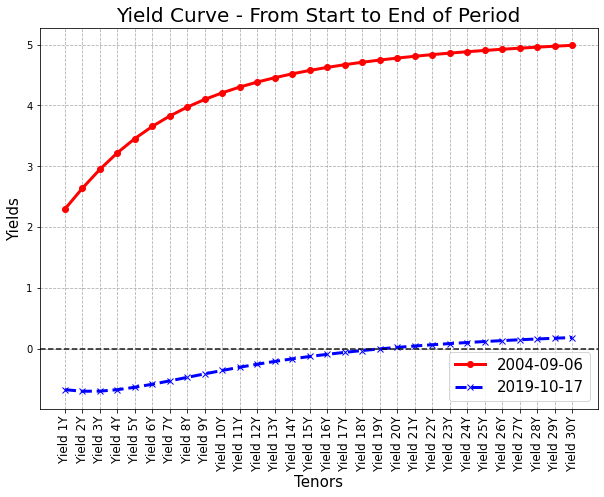

In [13]:
# 以下也是为了帮大家理解本题任务，不用操作
# 画出第一天和第二天的债券收益率曲线
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(yields_df.iloc[0],linestyle='-',marker='o',color='r',lw=3, label='2004-09-06')
ax.plot(yields_df.iloc[-1],linestyle='--',marker='x',color='b',lw=3, label='2019-10-17')
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.grid(linestyle='--')
ax.legend(loc = 'lower right', frameon=True, fontsize=15)
ax.xaxis.set_tick_params(rotation=90,labelsize=12)
ax.set_xlabel('Tenors', fontsize=15)
ax.set_ylabel('Yields',  fontsize=15)
ax.set_title('Yield Curve - From Start to End of Period', fontsize=20)
yields = yields_df.to_numpy() # 可以选择用numpy

### 2.1.1 用PCA提取主成分：

In [14]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# fit a scaler on a training dataset:
scaler = StandardScaler(with_std=False)
scaler.fit(yields)
# transform train and test data using the traind transformer:
yields = scaler.transform(yields)

In [15]:
# PCA
from sklearn.decomposition import PCA

yields_pca_skl = PCA(random_state=300).fit(yields)
yields_trans_sck = yields_pca_skl.transform(yields)

In [16]:
yields_trans_sck.shape

(3868, 30)

2.1.2 绘制前3个主成分随时间的变化图：

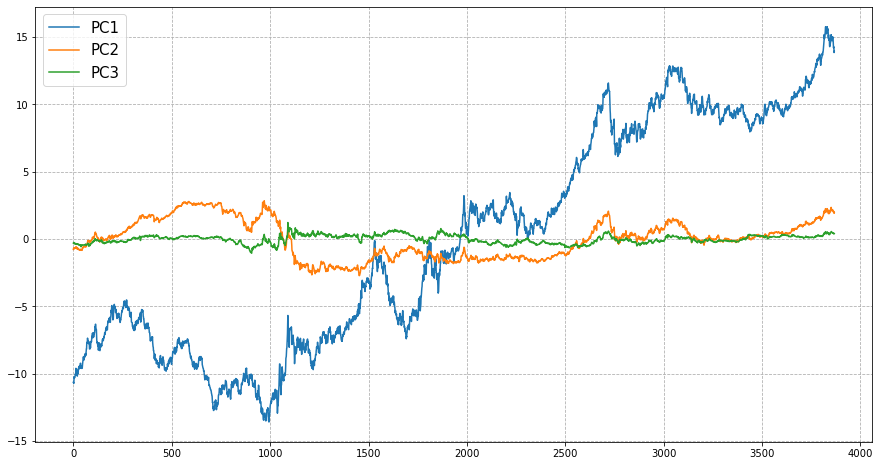

In [17]:
# Plot Principal Components:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(yields_trans_sck[:,0:3])
ax.grid(linestyle='--')
ax.legend(['PC1','PC2','PC3'],fontsize=15)

### 2.1.3 计算每个主成分解释的方差，并以合理的可视化。

In [18]:
# Compute the Explained variance for each PCs
variance_explained=np.round(yields_pca_skl.explained_variance_ratio_,4)
variance_explained_cum = [np.sum(variance_explained[0:i+1]) for i in range(variance_explained.shape[0])]

# Create index and columns name for the Dataframe:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9']
index = ['variance_explained','variance_explained_cum']
# 
variance_analysis_df=pd.DataFrame(index=index,columns=columns)
variance_analysis_df.loc['variance_explained',:]=variance_explained[:9]
variance_analysis_df.loc['variance_explained_cum',:]=variance_explained_cum[:9]

In [19]:
display(variance_analysis_df.style.format("{:.2%}"))

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
variance_explained,96.92%,2.90%,0.13%,0.04%,0.01%,0.00%,0.00%,0.00%,0.00%
variance_explained_cum,96.92%,99.82%,99.95%,99.99%,100.00%,100.00%,100.00%,100.00%,100.00%


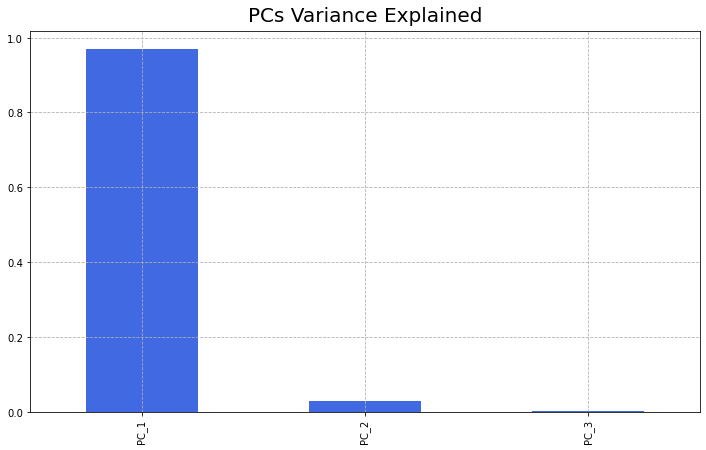

In [20]:
fig, ax = plt.subplots(figsize=(12,7))
variance_analysis_df.loc['variance_explained',['PC_1','PC_2','PC_3']].plot(kind='bar',ax=ax, color='royalblue')
#variance_analysis_df.loc['variance_explained_cum',['PC_1','PC_2','PC_3']].plot(kind='line',ax=ax,color='r');
ax.grid(linestyle='--')
ax.set_title('PCs Variance Explained', fontsize=20, y=1.01);
# To save the figure activate the line below and replace the correct path
#plt.savefig('Pictures/var_explained.png',dpi=75,bbox_inches='tight')

### 2.1.4 绘制特征向量：

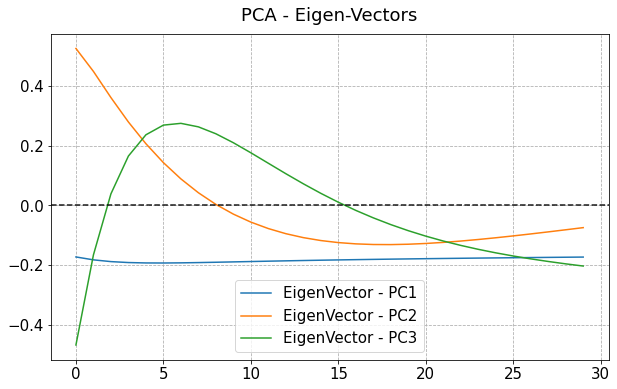

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(yields_pca_skl.components_[:3,:].T);
ax.grid(linestyle='--')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axhline(y=0,ls='--',c='k',alpha=0.9)
ax.set_title('PCA - Eigen-Vectors', fontsize=18, y=1.02);
ax.legend(['EigenVector - PC1','EigenVector - PC2','EigenVector - PC3'],loc = 'lower center', frameon=True, fontsize=15)

### 2.1.5 分别用第1个，前2个，前3个因子重建最近一天（2019年10月17日）的yield curve.

对比三张图：你能给每个PC取个名字吗？（不算分，经管同学可以好好想想）

In [22]:
def PCA_reconstruct(dim):

    # Recalculate the entire yield using the first 3 PCs for a specific day:
    yield_curve_pc_123 = np.dot(yields_trans_sck[-1,0:dim], yields_pca_skl.components_[0:dim,:])
    # Return the rates to their original scale:
    yield_fc = scaler.inverse_transform(yield_curve_pc_123)
    #store the date of the seleced day:
    date=yields_df.index[-1]
    #Plot the two Yield curves:
    fig, ax = plt.subplots(figsize=(12,7))

    ax.plot(yield_fc,label='Reconstructed Yield Curve')
    ax.plot(yields_df.iloc[-1],label='Actual Yield Curve')
    ax.xaxis.set_tick_params(rotation=90,labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.grid(linestyle='--')
    ax.legend(['reconstructed','original'],loc = 'lower center', frameon=True, fontsize=15)

    ax.set_xlabel('Tenor', fontsize=15)
    ax.set_ylabel('Yield', fontsize=15)
    ax.set_title('Actual and {}-PC Reconstructed Yield Curve Channge on the {:%d, %b %Y}'.format(dim,date), fontsize=20)

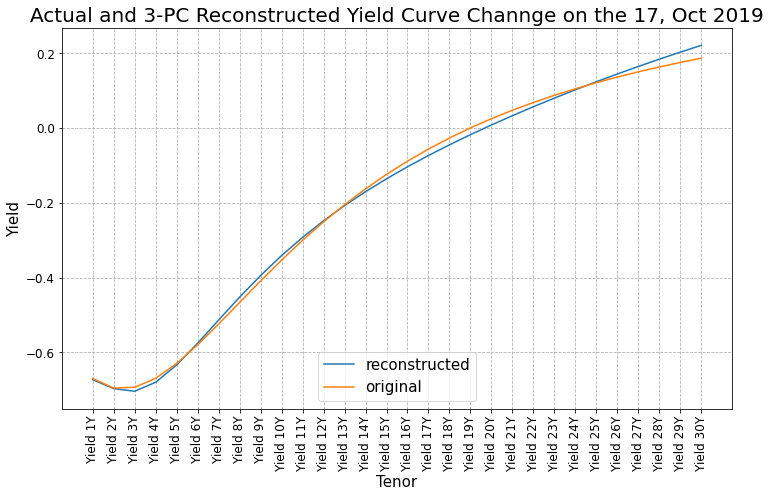

In [23]:
PCA_reconstruct(3)

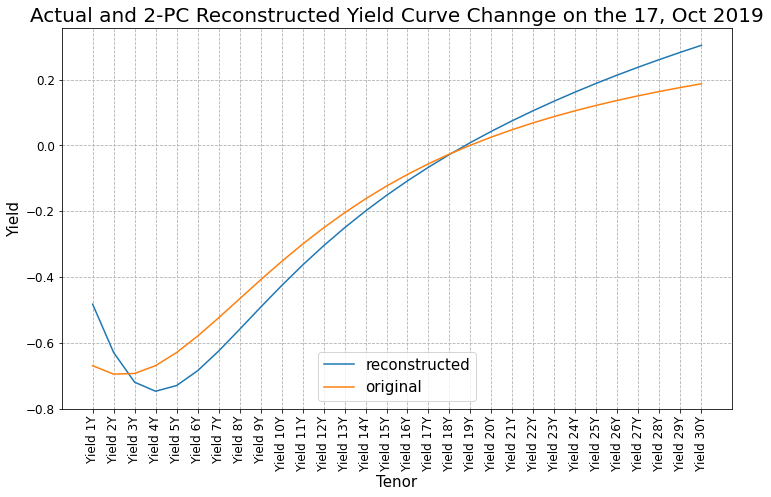

In [24]:
PCA_reconstruct(2)

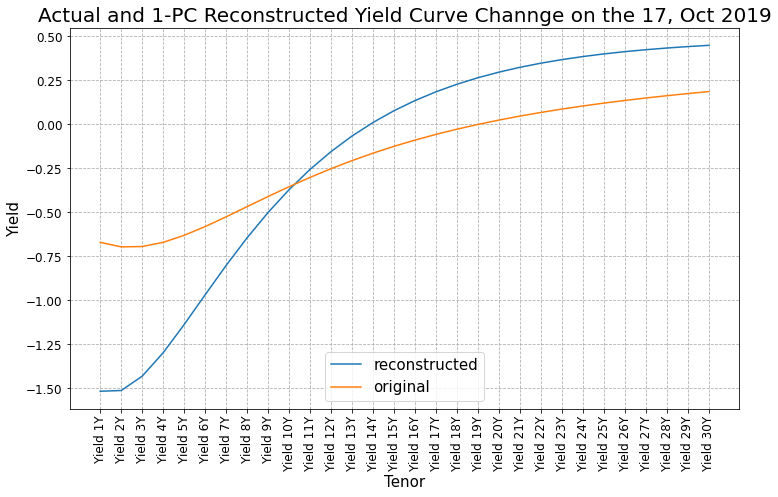

In [25]:
PCA_reconstruct(1)

### 2.2 numpy综合与聚类：图片处理与颜色压缩

计算机图形学中，颜色可以被量化为颜色空间。彩色图像一般有红绿蓝三个通道，每个通道取值通常为0~255。如果两个像素点只是在单个通道只有细微差异（例如R197G255B25和R198G255B25），在存储上也是不同的，但从观感来讲这两种色彩对我们来说基本没有区别。色彩量化就是找到一些具有代表性的颜色（16,32,64种）来表示全图像，量化前每个像素需要3bit存储，量化后只需要存储其色彩标号（1bit），因此使得需要的存储空间大大减小。

首先我们有一张猫猫图，来自于北大猫协的公众号。


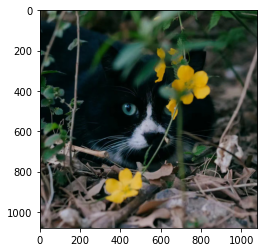

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.figure()
img = plt.imread('./cat.jpeg')
plt.imshow(img)

把颜色分布画在3维度坐标图上，颜色使用点对应的颜色。

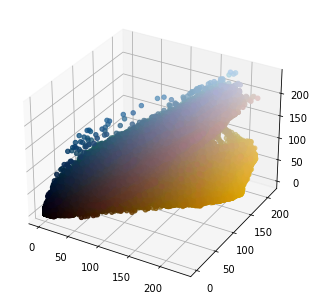

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
shape = img.shape
I = img.reshape(shape[0]*shape[1], shape[2])
ax.scatter(I[:,0],I[:,1],I[:,2],c=I.reshape(-1, 3)/255)
plt.show(ax)

##### 想法一（naive approach）：计算特定颜色的使用次数，并使用最常见的颜色进行量化（量化到16色）


1. 加载图片
2. 找出独特颜色的数量及其频率
3. 找到n most frequent colors
4. 用最接近的颜色替换原始图像中的颜色（计算距离，可以使用scipy.spatial包）
5. 保存与展示

(127936, 3) (127936,)


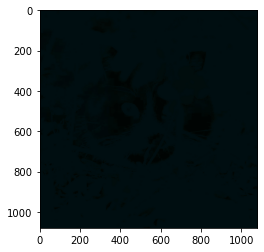

In [46]:
import scipy.spatial

# Number of final colors we want
n = 16

# Original Image
I = plt.imread("cat.jpeg")
shape = I.shape

# Flattened image
I = I.reshape(shape[0]*shape[1], shape[2])

# Find the unique colors and their frequency (=counts)
colors, counts = np.unique(I, axis=0, return_counts=True)
print(colors.shape,counts.shape)

# Get the n most frequent colors
sorted = np.argsort(counts)[::-1]
C = colors[sorted][:n]

# Compute distance to most frequent colors
D = scipy.spatial.distance.cdist(I, C, 'sqeuclidean')

# Replace colors with closest one
Z = (C[D.argmin(axis=1)]).reshape(shape)

# Save and display result
plt.figure()
plt.imsave("cat_dithered.jpeg", Z)
plt.imshow(Z)

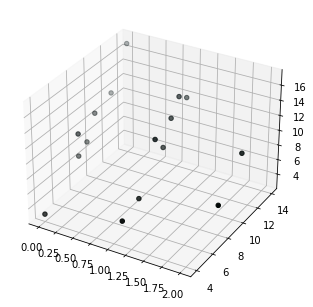

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(C[:,0],C[:,1],C[:,2],c=C.reshape(-1, 3)/255)
plt.show(ax)

##### 想法二（sophisticated approach）：K-Means

可以看到上面的方法颜色的失真十分严重，这是因为一些颜色比较微小的变化可能在原始图像中被过度表达，因此将出现在最常见的颜色中。我们需要另一种方法：也就是我们课上讲过的kmeans方法。请在如下的block中实现。同样只保留16色。

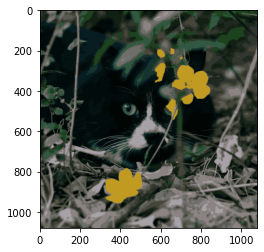

In [366]:
import numpy as np
import scipy.spatial

def cluster_centroids(data, clusters, k=None):
    if k is None:
        k = np.max(clusters) + 1
    result = np.empty(shape=(k,) + data.shape[1:])
    for i in range(k):
        np.mean(data[clusters == i], axis=0, out=result[i])
    return result


def kmeans(data, k=None, centroids=None, steps=20):
    if centroids is not None and k is not None:
        assert(k == len(centroids))
    elif centroids is not None:
        k = len(centroids)
    elif k is not None:
        # Forgy initialization method: choose k data points randomly.
        centroids = data[np.random.choice(np.arange(len(data)), k, False)]
    else:
        raise RuntimeError("Need a value for k or centroids.")

    for _ in range(max(steps, 1)):
        # Squared distances between each point and each centroid.
        sqdists = scipy.spatial.distance.cdist(centroids, data, 'sqeuclidean')

        # Index of the closest centroid to each data point.
        clusters = np.argmin(sqdists, axis=0)

        new_centroids = cluster_centroids(data, clusters, k)
        if np.array_equal(new_centroids, centroids):
            break

        centroids = new_centroids
    return centroids, clusters


if __name__ == '__main__':

    # Number of final colors we want
    n = 16

    # Original Image
    I = plt.imread("cat.jpeg")
    shape = I.shape

    # Flattened image
    D = I.reshape(shape[0]*shape[1], shape[2])
    
    # Search for 16 centroids in D (using 20 iterations)
    centroids, clusters = kmeans(D, k=n, steps=20)

    # Create quantized image
    I = (centroids[clusters]).reshape(shape)
    I = np.round(I).astype(np.uint8)

    # Save result
    plt.figure()
    plt.imsave("cat_quantized.jpeg", I)
    plt.imshow(I)

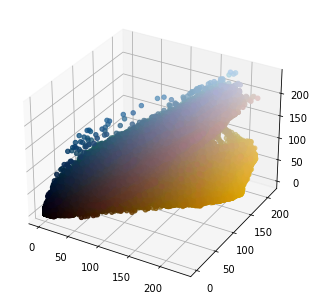

In [228]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

I = I.reshape(shape[0]*shape[1], shape[2])
img_reshaped = img.reshape(shape[0]*shape[1], shape[2])

ax.scatter(img_reshaped[:,0],img_reshaped[:,1],img_reshaped[:,2],c=I.reshape(-1, 3)/255)

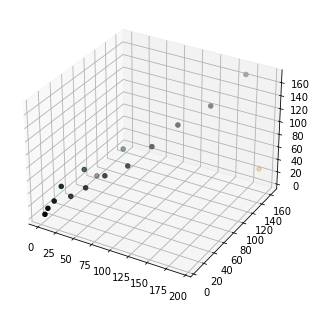

In [368]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],c=centroids.reshape(-1, 3)/255)

### 附加题：PCA的另类用法

在著名的神经网络论文AlexNet中曾提出了一种使用PCA进行数据增强的算法，称之为PCA jitter。所谓数据增强，就是通过对训练数据人为的加噪声，提高模型鲁棒性与预测能力的方法。从观感来讲，PCA jitter近似对光效的变化，对比直接对RGB通道进行加噪声会获得更少的颜色的失真。请尝试按如下步骤对猫猫图基于PCA进行augmentation，生成4个结果并展示。


1. 将图片按照RGB三通道标准化，均值为0，方差为1。
2. 将图片按照channel展平成大小为(*, 3)的array
3. 对上述array求协方差矩阵
4. 对协方差矩阵进行特征分解
5. 对特征值进行“抖动”，抖动幅度自行设定，可以同样从正态分布中抽样
6. 还原图片（想想如何还原？需要进行一些数学推演）并展示

如果你能按照上面的步骤操作下来，一定会对PCA有更深刻的理解！

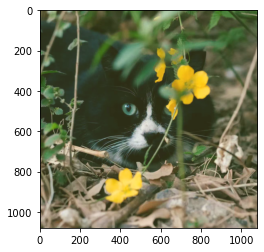

In [194]:
import numpy as np

def pca_color_augmentation(image_array_input):
    assert image_array_input.ndim == 3 and image_array_input.shape[2] == 3
    assert image_array_input.dtype == np.uint8

    img = image_array_input.reshape(-1, 3).astype(np.float32)
    img = (img - np.mean(img, axis=0)) / np.std(img, axis=0)

    cov = np.cov(img, rowvar=False)
    lambd_eigen_value, p_eigen_vector = np.linalg.eig(cov)

    rand = np.random.randn(3) * 0.2
    delta = np.dot(p_eigen_vector, rand*lambd_eigen_value)
    delta = (delta * 255.0).astype(np.int32)[np.newaxis, np.newaxis, :]

    img_out = np.clip(image_array_input + delta, 0, 255).astype(np.uint8)
    return img_out

plt.imshow(pca_color_augmentation(plt.imread("cat2.jpeg")))